<div style="text-align: right"> 2018-06-09 </div>


## <div style="color:green; text-align: center">  Módulo 17 - CASO ANALÍTICA DE OPERACIONES <br>  Actividad 4 Ejercicio Práctico </div>

### Master Business Intelligence y Big Data

**PROFESOR** <br>
Juan Ramón González <br>
jrgonzalez@maticapartners.com <br>

**ALUMNO** <br>
Christian Vasquez Hernandez <br>
cvasquezhernandez@learning.eoi.es

***

## Caso de Analítica de Operaciones:

### Introducción:

Dentro de la operación habitual del banco, se os ha pedido que mejoréis el proceso del marco regulatorio y de
cumplimiento normativo. Para ello debéis mejorar las herramientas internas del banco para detectar casos
potenciales de fraude en operaciones transaccionales.


Vuestra primera aproximación fue realizar un modelo de clasificación (presentado en las actividades prácticas
guiadas) con el que habéis conseguido unos primeros resultados prometedores.


Debido a que el dataset que os ha puesto a disposición el banco están muy desbalanceados, habéis decidido
cambiar la aproximación del trabajo, cambiando la aproximación de un modelo de clasificación a un modelo
de estimación de anomalías. Es decir, vais a cambiar el modelo de un sistema supervisado a uno no
supervisado, esperando obtener iguales o mejores resultados.


Para ello, la unidad operativa os ha dado ciertas indicaciones:
- El coste de analizar una operación de forma manual para evaluar su fraudulencia es de 3 horas, con un coste del técnico de análisis de 35 euros la hora.
- El coste de no reportar una operación fraudulenta a los organismos pertinentes es una multa de 10.000 euros y la probabilidad de ser multados es de un 2%

### Descripción de la practica:

Se pide al alumno que desarrolle un caso de detección de anomalías usando el dataset proporcionado en los
casos guiados: FraudOps.csv y sobre el que es necesario:
- Realizar un análisis descriptivo del dataset (EDA).
- Realizar una reducción dimensional sobre los datos de entradas- Aplicar un modelo de clustering (k-means o similar) para separar en grupos de comportamientos las operaciones.
- Usar la información etiquetada de fraude/no fraude, para visualizar los grupos de comportamiento de forma que se intente separar de la mejor forma posible clusters con datos fraudulentos y clusters de datos no fraudulentos.
- Generar una medida del error del modelo, basado en la distancia de cada operación al centro de su cluster, como medida de “anomalía” de la operación.
- Definir un umbral de “anomalía” por encima del cual se estima que la información es fraudulenta
- Separar el dataset en datos de entrenamiento y datos de test y realizar una operación de cross-validation para encontrar el umbral óptimo que maximice el acierto del modelo.

### Entregables:

El alumno deberá entregar:
- Un fichero de notebook con su código comentado
- Una breve presentación donde se explique a un usuario de negocio el proceso realizado y los resultados obtenidos. En esta presentación se debe realizar:

    * Introducción de la aproximación tomada
    * Presentar resultados de forma visual, tanto aquellos que consideréis importantes del proceso como del resultado final.
    * Realizar un análisis y justificación de las decisiones tomadas, especialmente analizando el impacto de falsos positivos del modelo vs falsos negativos y el impacto económico que conllevará.


---

## Desarrollo de la actividad:

La actividad la voy a resumir en 10 puntos, sobre lo revisado en la videoconferencia:

1. Analitica Exploratoria y Normalización.
2. Aplicar PCA. A cuantas dimensiones, averiguar y justificar.
3. Dataset Reducido dimensionalmente.
4. Aplicar KMeans, con Nro Clusteral, averiguarlo
5. Visualizar.
6. Calculo de la distancia de centroides. De cada punto al centro (plt.scatter).
7. Cluster 4-6 (buscar el umbral en cada uno de ellas).
	* Cross Validation
	* Método Iterativo para encontrar el umbral optimo.
8. Umbral por encima del fraudulento, y por debajo del que se tiene el dato correcto. 
9. Falsos positivos y falsos negativos.
10. Justificar el valor.


### 1. Analitica Exploratoria y Normalización

Cargamos las librerias necesarias asi como el dataset, entregado, para esto vamos a tomar el mismo ejemplo de la practica.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

RANDOM_SEED = 42
n_dim = 64

plt.style.use('bmh')

#### Cargando la información y explorando los valores

In [2]:
df = pd.read_csv('./FraudInputDatav2.csv', encoding = "utf-16") #leemos el fichero de datos, codificado en utf-16

Conteo rapido de filas y columnas

In [3]:
df.shape

(62763, 74)

Visualizamos los primeros registros del dataset. 

In [4]:
df.head()

,ID,ac,ab,N1,NCE,pm,Value,Credit,Channel,Product,...,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud,random,sample,FraudStr
0,1,0.445878,-0.359697,0,0,credit_card,-0.258301,0,CD,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.027303,train,Good
1,2,-0.782197,-0.632741,0,0,credit_card,-0.258301,0,CE,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.028333,train,Good
2,3,0.298404,0.927510,0,0,credit_card,-0.275540,0,CD,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.008819,check,Good
3,4,-0.664740,2.472159,0,0,credit_card,-0.274538,1,CE,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.038630,train,Good
4,5,-0.223625,-0.617138,0,0,credit_card,-0.218079,0,CD,CA,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.000657,train,Good


Separamos las variables categóricas en un dataset distintos:

In [5]:
#vamos a linealizar las variables categoricas usando un one-hot-enconding
#para eso el primer paso es encontrar todas las variables categoricas, seran aquellas que tengan el tipo object
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()
#como podeis ver el dataset tiene 8 variables categoricas. No linealizaremos FraudStr y sample ya que serán borradas posteriormente

,pm,Channel,Product,sl,le,Routing,sample,FraudStr
0,credit_card,CD,F,0,YYY,mobile gateway,train,Good
1,credit_card,CE,F,0,YYY,fixed,train,Good
2,credit_card,CD,CB,EU,YYY,fixed,check,Good
3,credit_card,CE,CB,0,YYY,pop,train,Good
4,credit_card,CD,CA,0,YYY,fixed,train,Good


LLevamos las variables categoricas hacia valores en relación de su valor de train/check y su target

In [6]:
##realizamos la codificación
df_encoding = pd.get_dummies(obj_df, columns=['pm','Channel','Product','sl','le','Routing'])
df_encoding.head()
#como podeis ver se ha creado una columna por cada valor de las variables categoricas.
#Por ejemplo la variable payment ha sido convertida a 4 variables numéricas

,sample,FraudStr,pm_clicknbuy,pm_credit_card,pm_payease,pm_paypal,pm_store_credit,Channel_A,Channel_BA,Channel_BB,...,Routing_aolpop,Routing_aolproxy,Routing_cache proxy,Routing_fixed,Routing_international proxy,Routing_mobile gateway,Routing_none,Routing_pop,Routing_regional proxy,Routing_satellite
0,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,check,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
df_encoding.shape

(62763, 50)

In [8]:
#obtenemos el resto de variables para concatenarlo en el df de trabajo
num_df = df.select_dtypes(include=['int64','float64']).copy()
df_num = pd.concat([df_encoding,num_df], axis=1).drop('ID',1).drop('random', 1).drop('sample', 1).drop('FraudStr', 1) #aprovecho para quitar columnas no necesarias
df_num.head()

,pm_clicknbuy,pm_credit_card,pm_payease,pm_paypal,pm_store_credit,Channel_A,Channel_BA,Channel_BB,Channel_BC,Channel_C,...,N5_Prods_Card,N5_Prods_IP,N5_Accounts_Device,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud
0,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
4,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [9]:
df_num.shape

(62763, 112)

Estudiamos el resto de variables

In [10]:
y=df_num.Fraud
x=df_num.drop(['Fraud','Value'],axis=1) ## Quitamos la variable Value y la etiqueta Fraud

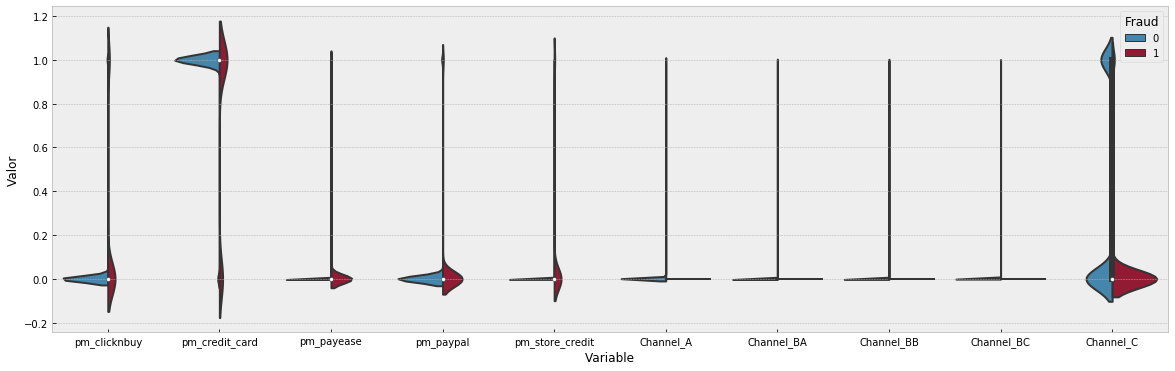

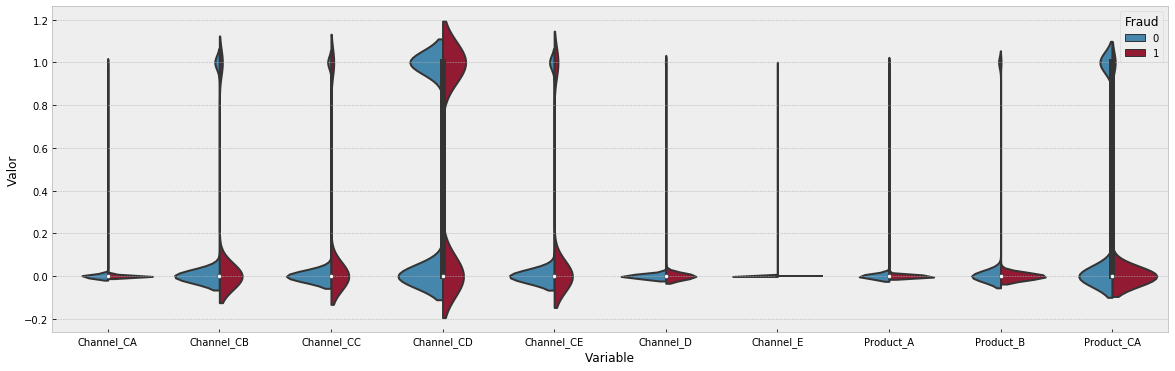

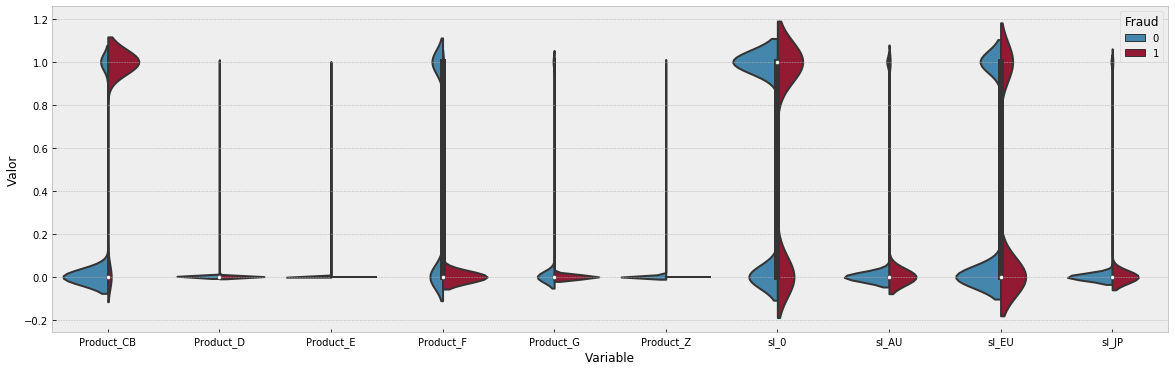

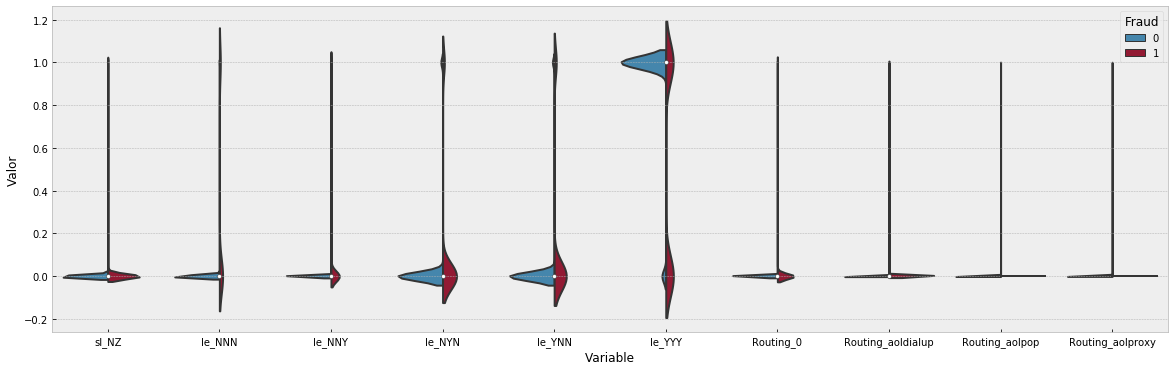

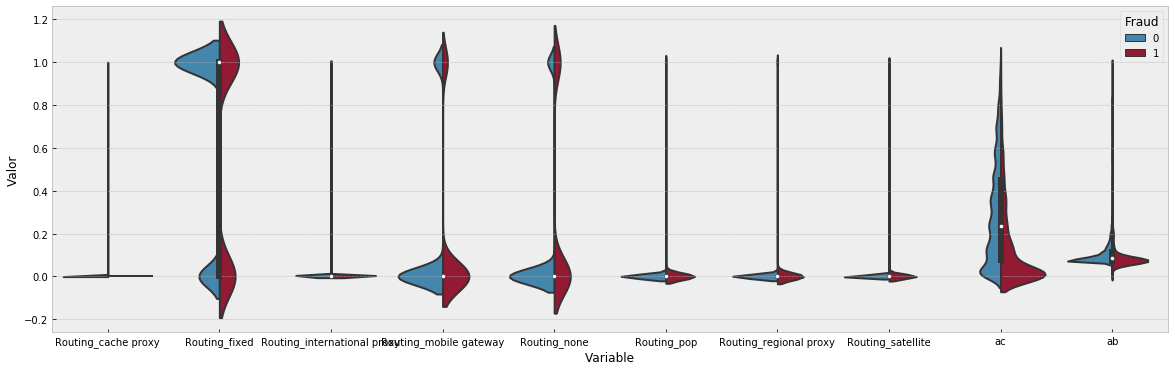

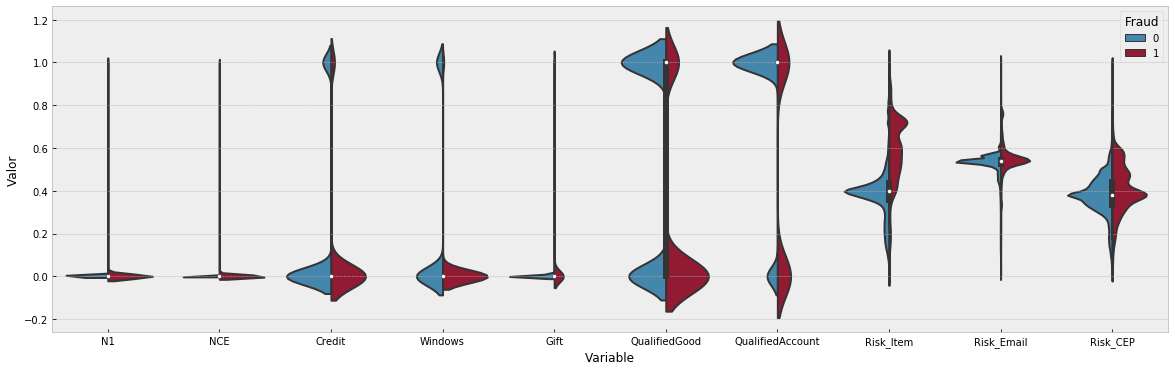

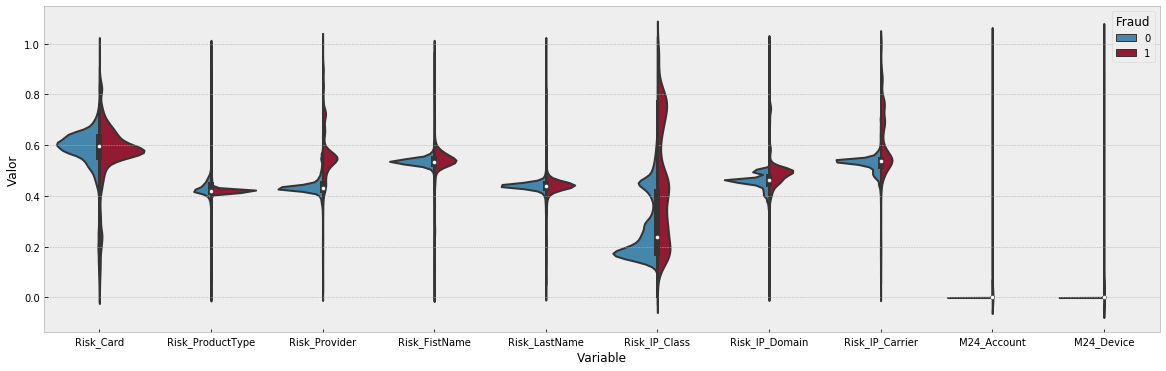

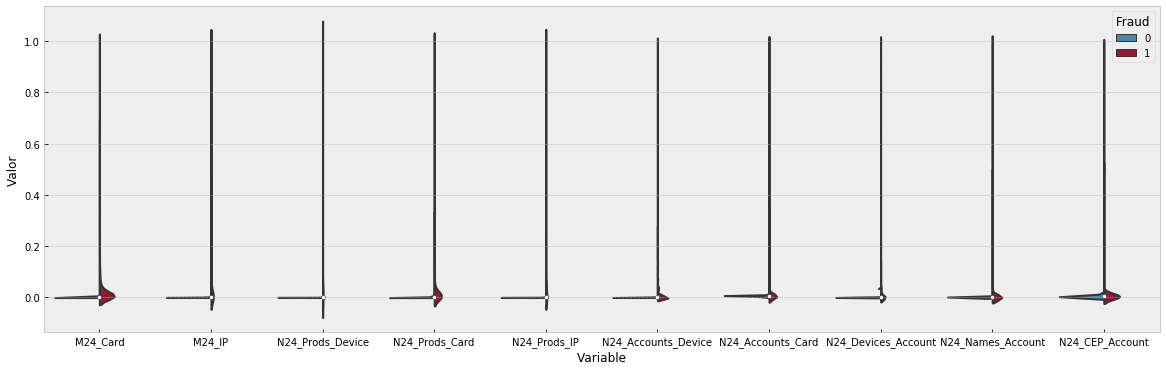

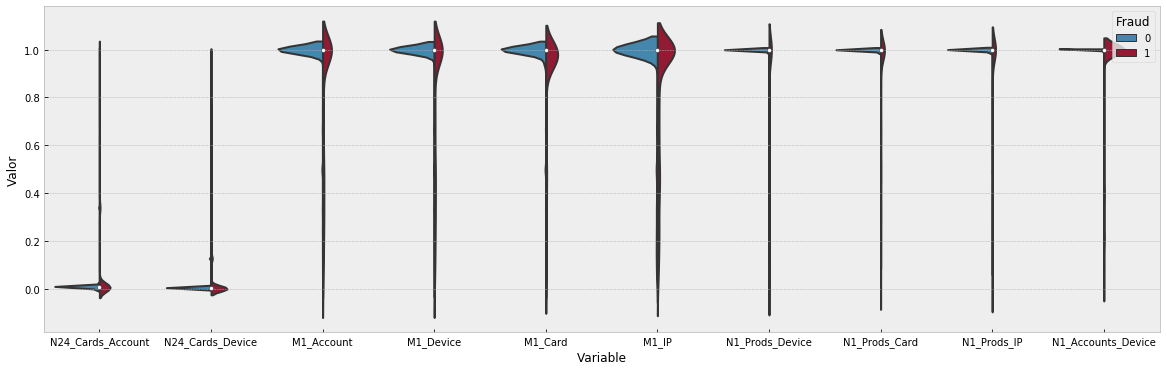

In [11]:
#Primer grupo de variables (0-60) La generación de estas gráficas lleva algo de tiempo de computo
x_scaled=(x-x.min())/(x.max()-x.min()) 
sub_df1=pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
sub_df2=pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
sub_df3=pd.concat([y,x_scaled.iloc[:,20:30]],axis=1)
sub_df4=pd.concat([y,x_scaled.iloc[:,30:40]],axis=1)
sub_df5=pd.concat([y,x_scaled.iloc[:,40:50]],axis=1)
sub_df6=pd.concat([y,x_scaled.iloc[:,50:60]],axis=1)
sub_df7=pd.concat([y,x_scaled.iloc[:,60:70]],axis=1)
sub_df8=pd.concat([y,x_scaled.iloc[:,70:80]],axis=1)
sub_df9=pd.concat([y,x_scaled.iloc[:,80:90]],axis=1)

sub_df11=pd.melt(sub_df1,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df22=pd.melt(sub_df2,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df33=pd.melt(sub_df3,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df44=pd.melt(sub_df4,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df55=pd.melt(sub_df5,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df66=pd.melt(sub_df6,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df77=pd.melt(sub_df7,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df88=pd.melt(sub_df8,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df99=pd.melt(sub_df9,id_vars="Fraud",var_name="Variable",value_name='Valor')

plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df11, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df22, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df33, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df44, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df55, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df66, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df77, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df88, split=True)
plt.figure(figsize=(20,6))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df99, split=True)



In [12]:
#borramos columnas con una distribución uniforme entre fraude y no fraude
df_features=df_num.drop(['Channel_BA','Channel_BB','Channel_BC','Channel_CA','Channel_D','Channel_E','Product_A','Product_B','Product_CA','Product_D','Product_E','Product_G','Product_Z','sl_JP','sl_NZ','Routing_0','Routing_aoldialup','Routing_aolpop','Routing_aolproxy','Routing_cache proxy','Routing_pop','Routing_regional proxy','Routing_satellite','ac','ab','N1','NCE','QualifiedGood','Risk_Email','Risk_CEP','Risk_Card','Risk_FistName','Risk_LastName','Risk_IP_Class','Risk_IP_Domain','Risk_IP_Carrier'],axis=1)
df_features.head()

,pm_clicknbuy,pm_credit_card,pm_payease,pm_paypal,pm_store_credit,Channel_A,Channel_C,Channel_CB,Channel_CC,Channel_CD,...,N5_Prods_Card,N5_Prods_IP,N5_Accounts_Device,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud
0,0,1,0,0,0,0,0,0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,0,1,0,0,0,0,0,0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,0,1,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
4,0,1,0,0,0,0,0,0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


#### Normalizando :

Buscamos cuales son las variables que son necesarias a normalizar, ya que sus maximos y minimos exceden los rangos esperados.


In [13]:
tt = df_features.describe().transpose()
tt[(tt['max']>1) & (tt['min']< -1)]

,count,mean,std,min,25%,50%,75%,max
Risk_Item,62763.0,-1.389215e-14,0.972078,-2.935098,-0.301426,0.000000,0.257719,4.407077
Risk_ProductType,62763.0,3.128379e-15,0.882261,-6.053142,-0.038964,0.000000,0.326596,8.362492
Risk_Provider,62763.0,1.202075e-14,0.998916,-6.767770,-0.310101,-0.187156,0.046344,8.439375


Existen tres variables con las que se deben trabajar, la normalización:

In [14]:
columns_to_norm = ['Risk_Item','Risk_ProductType','Risk_Provider']

Para estas tres dimensiones, ajustamos sus escala conel metodo **MinMaxScaler** de la libreria __scikit learn__.

In [15]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_features[columns_to_norm]=min_max_scaler.fit_transform(df_features[columns_to_norm])

Analizamos las variables para ver las mas importantes, las que tengan mejor correlación

In [16]:
df_features.shape

(62763, 76)

In [30]:
# Estudiamos el resto de variables
y=df_features.Fraud
x=df_features.drop('Fraud',axis=1)

In [32]:
#PCA
n_dim = 75
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=n_dim, whiten=True)
sklearn_pca.fit(x)
features_pca = pd.DataFrame(data = sklearn_pca.transform(x))

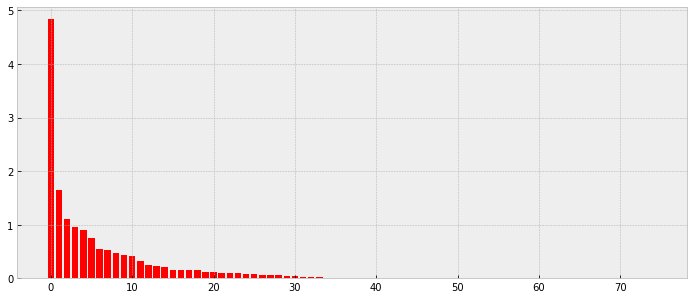

In [33]:
plt.figure(figsize=(12, 5))
rects1 = plt.bar(np.arange(n_dim),sklearn_pca.explained_variance_, color='r')

In [34]:
features_pca= pd.concat([features_pca, y], axis=1)

### Selección de Variables

Aplicaremos la tecnica de random forest, para saber escoger cuales son las mas relevantes.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test = train_test_split(features_pca, test_size=0.2, random_state=RANDOM_SEED)
Y_train = X_train['Fraud']
X_train = X_train.drop(['Fraud'], axis=1)
Y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

In [36]:
from sklearn.ensemble import RandomForestClassifier

delta = 0.001
n_vars =n_dim
X_train_red = X_train.copy()
X_test_red = X_test.copy()
scores = []
count = 0

In [39]:
xejem =  df_features.drop('Fraud',axis=1)

In [46]:
from sklearn import metrics
n_estimators = 10
n_dim_init = n_dim
X_train_red = X_train_red[X_train_red.columns[0:n_vars-1]]
X_test_red = X_test_red[X_test_red.columns[0:n_vars-1]]
    
rf =RandomForestClassifier(n_estimators, max_depth=None,  random_state=0, n_jobs=-1)
rf.fit(X_train_red, Y_train)
Y_pred = rf.predict(X_test_red)
pscore = metrics.recall_score(Y_test, Y_pred, average ='binary')
n_vars = n_vars-1
thresold = 0.01

scores.append(pscore)
count = count+1

importances = list(rf.feature_importances_)
imp_index = importances.index(min(importances))

while((delta > thresold) | ( n_vars >1)):
    
    X_train_red= X_train_red.drop(X_train_red.columns[[imp_index]],axis=1)
    X_test_red =X_test_red.drop(X_test_red.columns[[imp_index]],axis=1)
    
    rf =RandomForestClassifier(n_estimators, max_depth=None,  random_state=0, n_jobs=-1)
    rf.fit(X_train_red, Y_train)
    Y_pred = rf.predict(X_test_red)
    pscore_new = metrics.recall_score(Y_test, Y_pred, pos_label = 1, average ='binary')
    delta = pscore_new-pscore
    pscore = pscore_new
    n_vars =n_vars-1
    scores.append(pscore)
    count= count+1
    importances = list(rf.feature_importances_)
    imp_index = importances.index(min(importances))

n_dim=n_dim_init

#### Visualizamos el error a medida que quitamos variables del sistema. Como veis, existe un conjunto de variables que no aportan casi información al resultado, y otro conjunto que supone una caida drástica de los resultados del modelo.

scores

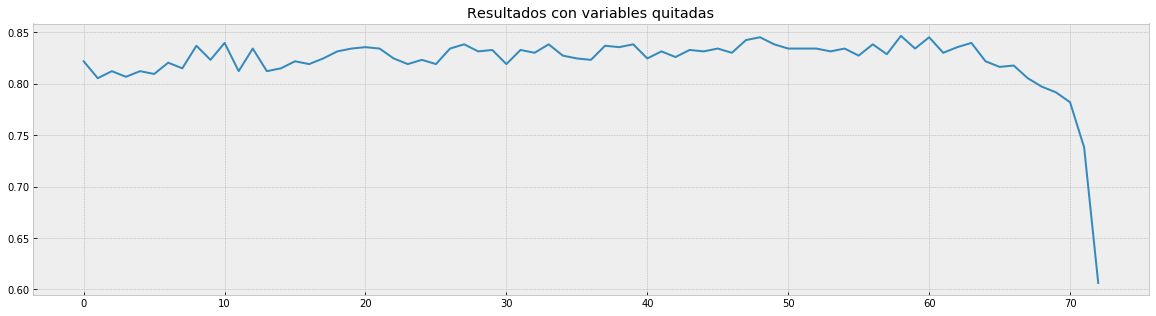

In [47]:
plt.figure(figsize=(20, 5))
plt.title('Resultados con variables quitadas')
plt.plot(np.arange(0,n_dim-1, 1),scores)

#### BALANCEO DE DATASET Y NORMALIZACIÓN DE DATOS

Vamos a descubrir si el dataset esta balanceado:

# PREPARACIÓN DE DATOS PARA APRENDIZAJE Y LANZAMIENTO DE MODELO

In [30]:
from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(df_features, test_size=0.2, random_state=RANDOM_SEED)
Y_train = X_train['Fraud']
X_train = X_train.drop(['Fraud'], axis=1)
Y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

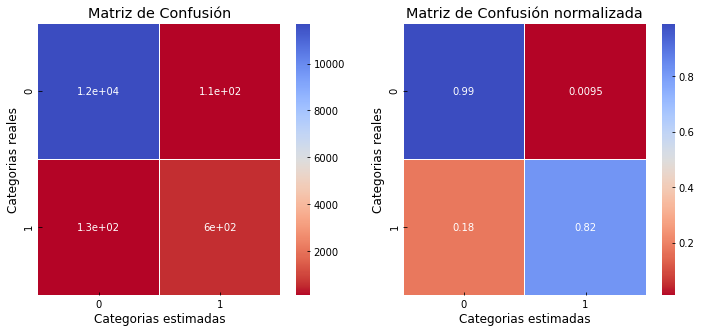

---Report de clasificación---
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     11824
          1       0.84      0.82      0.83       729

avg / total       0.98      0.98      0.98     12553



In [31]:
from sklearn import metrics

sgd_clf=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

sgd_clf.fit(X_train, Y_train) 
Y_train_predicted=sgd_clf.predict(X_train)
Y_test_predicted=sgd_clf.predict(X_test)

plot_confusion_matrix(Y_test, Y_test_predicted)

# DESBALANCEAR EL DATASET

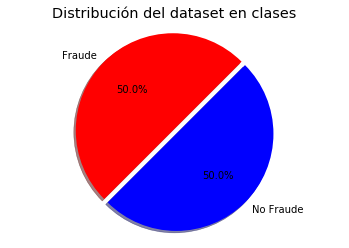

In [32]:
from sklearn.utils import shuffle

Train_Data= pd.concat([X_train, Y_train], axis=1)
X_1 =Train_Data[ Train_Data["Fraud"]==1 ]
X_0=Train_Data[Train_Data["Fraud"]==0]

X_0=shuffle(X_0,random_state=42).reset_index(drop=True)
X_1=shuffle(X_1,random_state=42).reset_index(drop=True)

ALPHA=1 #sobre esta variable podeis jugar para cambiar la distribución del dataset

X_0=X_0.iloc[:round(len(X_1)*ALPHA),:]
data_d=pd.concat([X_1, X_0])

count_classes = pd.value_counts(data_d['Fraud'], sort = True).sort_index()
labels = 'Fraude', 'No Fraude'
sizes = [count_classes[1]/(count_classes[1]+count_classes[0]), count_classes[0]/(count_classes[1]+count_classes[0])]
explode = (0, 0.05,)
colors = ['red', 'blue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribución del dataset en clases")
plt.show()

In [34]:
data_d.shape

(5950, 76)

In [35]:
Y_d=data_d['Fraud']
X_d=data_d.drop(['Fraud'],axis=1)

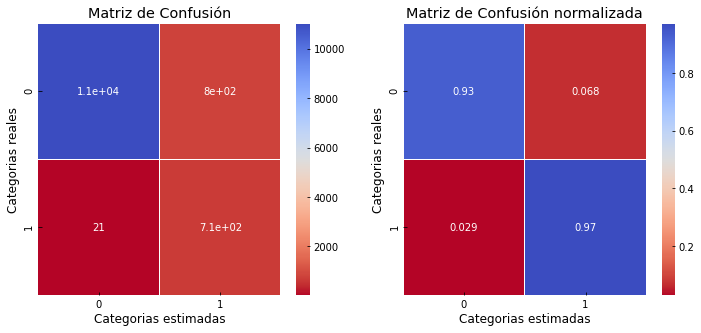

---Report de clasificación---
             precision    recall  f1-score   support

          0       1.00      0.93      0.96     11824
          1       0.47      0.97      0.63       729

avg / total       0.97      0.93      0.94     12553



In [36]:
sgd_clf_d=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

sgd_clf_d.fit(X_d, Y_d) 


Y_test_predicted=sgd_clf_d.predict(X_test)

plot_confusion_matrix(Y_test, Y_test_predicted)

# CORRELACIÓN DE VARIABLES

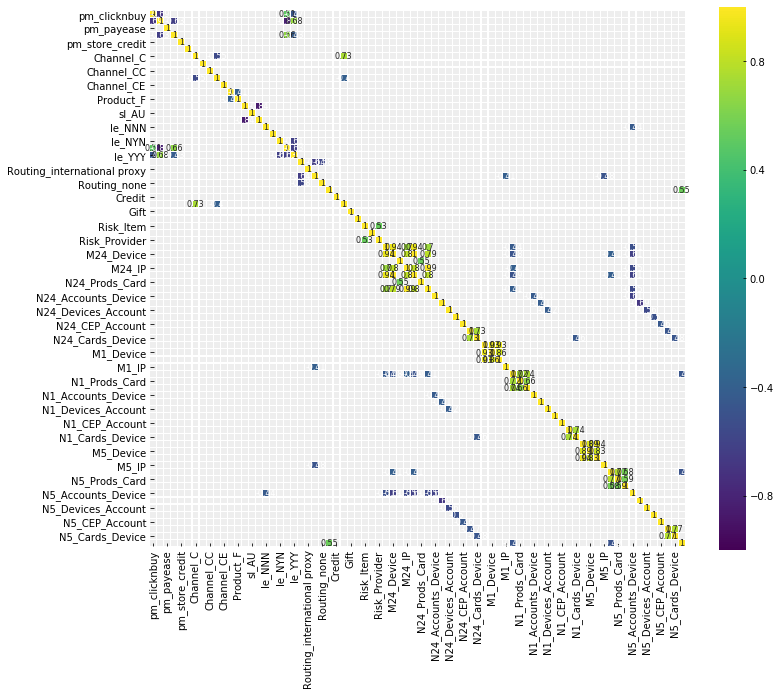

In [37]:
#generamos la matriz de correlación y miramos solamente aquellas variables con un nivel de correlación alto
corr_base = df_features.corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr_base[(corr_base >= 0.5) | (corr_base <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [38]:
# Estudiamos el resto de variables
y=df_features.Fraud
x=df_features.drop('Fraud',axis=1)

In [43]:
#PCA
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=n_dim, whiten=True)
sklearn_pca.fit(x)
features_pca = pd.DataFrame(data = sklearn_pca.transform(x))


[4.95372042e+00 1.96442995e+00 1.37044869e+00 1.09657415e+00
 9.56717122e-01 8.71031202e-01 7.44263513e-01 5.60645642e-01
 5.33384042e-01 5.22431408e-01 4.70411965e-01 4.52465862e-01
 4.18600660e-01 4.03520620e-01 3.09562282e-01 2.50640657e-01
 2.25594472e-01 2.18753991e-01 1.59182493e-01 1.54240928e-01
 1.47619367e-01 1.43740774e-01 1.24547018e-01 1.18327637e-01
 9.96048986e-02 9.06174082e-02 8.42294020e-02 7.56191541e-02
 7.48525081e-02 7.02313135e-02 5.81086060e-02 5.50118132e-02
 4.62488706e-02 4.37461983e-02 2.04626911e-02 2.00537552e-02
 1.49022591e-02 1.32921636e-02 9.41802298e-03 9.13159647e-03
 8.14937655e-03 7.13874690e-03 5.48151971e-03 4.98817945e-03
 4.28064768e-03 3.67898200e-03 3.51783172e-03 3.09924185e-03
 3.02410105e-03 2.91619244e-03 2.21008842e-03 2.01852940e-03
 1.46687148e-03 1.36663963e-03 1.35692730e-03 1.27232201e-03
 1.04996336e-03 9.22281179e-04 7.92393631e-04 7.82278753e-04
 7.22128632e-04 6.61325653e-04 5.49631937e-04 4.46245702e-04]


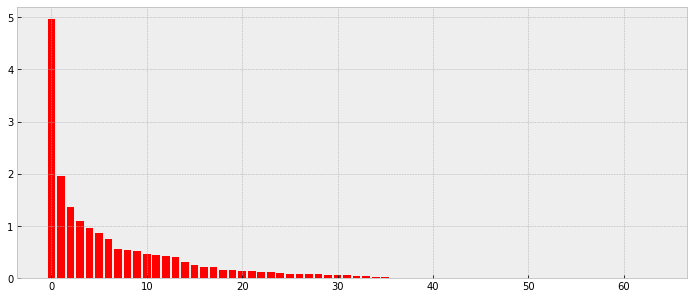

In [44]:
plt.figure(figsize=(12, 5))
rects1 = plt.bar(np.arange(n_dim),sklearn_pca.explained_variance_, color='r')
print(sklearn_pca.explained_variance_)  

In [45]:
# nos quedaremos con las primeras 32 variables
features_pca = features_pca.iloc[:,0:32]
features_pca.shape

(62763, 32)

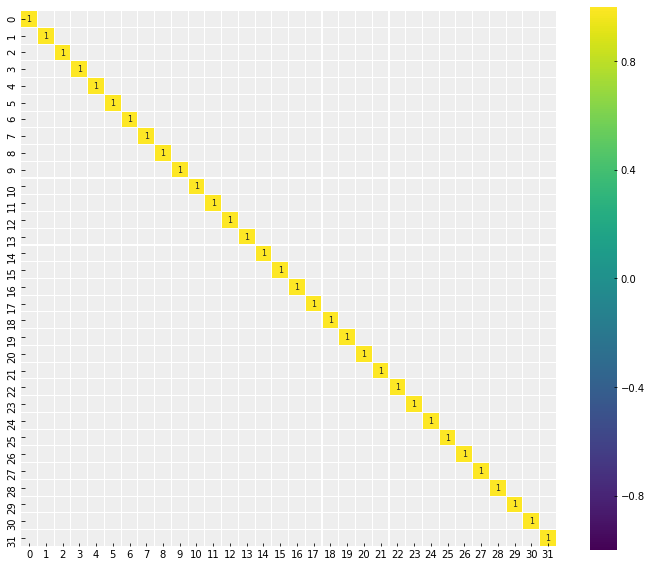

In [46]:
corr_pca = features_pca.corr() # We already examined Fraud correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_pca[(corr_pca >= 0.5) | (corr_pca <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [47]:
features_pca= pd.concat([features_pca, y], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(features_pca, test_size=0.2, random_state=RANDOM_SEED)
Y_train = X_train['Fraud']
X_train = X_train.drop(['Fraud'], axis=1)
Y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

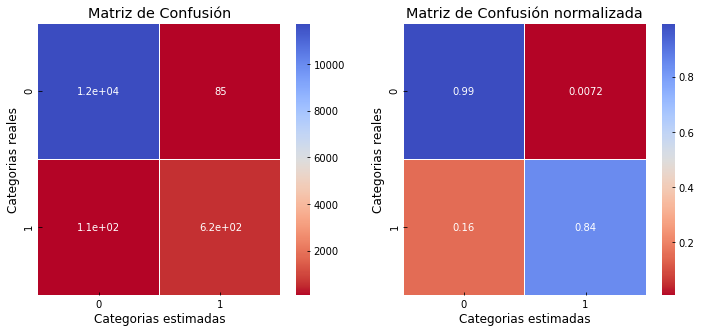

---Report de clasificación---
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     11824
          1       0.88      0.84      0.86       729

avg / total       0.98      0.98      0.98     12553



In [48]:

from sklearn.ensemble import RandomForestClassifier
rf =RandomForestClassifier(n_estimators=100, max_depth=None,  random_state=0)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
plot_confusion_matrix(Y_test, Y_pred)

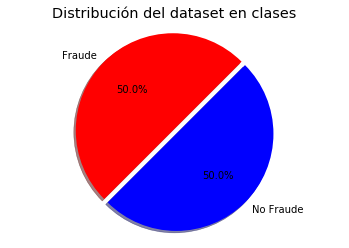

In [49]:
from sklearn.utils import shuffle

Train_Data= pd.concat([X_train, Y_train], axis=1)
X_1 =Train_Data[ Train_Data["Fraud"]==1 ]
X_0=Train_Data[Train_Data["Fraud"]==0]

X_0=shuffle(X_0,random_state=42).reset_index(drop=True)
X_1=shuffle(X_1,random_state=42).reset_index(drop=True)

ALPHA=1 #sobre esta variable podeis jugar para cambiar la distribución del dataset

X_0=X_0.iloc[:round(len(X_1)*ALPHA),:]
data_d=pd.concat([X_1, X_0])

count_classes = pd.value_counts(data_d['Fraud'], sort = True).sort_index()
labels = 'Fraude', 'No Fraude'
sizes = [count_classes[1]/(count_classes[1]+count_classes[0]), count_classes[0]/(count_classes[1]+count_classes[0])]
explode = (0, 0.05,)
colors = ['red', 'blue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribución del dataset en clases")
plt.show()

In [50]:
Y_d=data_d['Fraud']
X_d=data_d.drop(['Fraud'],axis=1)

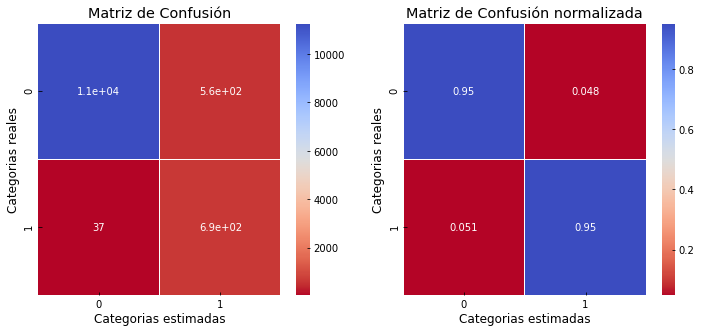

---Report de clasificación---
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     11824
          1       0.55      0.95      0.70       729

avg / total       0.97      0.95      0.96     12553



In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
rf =RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0, n_jobs=-1)
rf.fit(X_d, Y_d) 
Y_test_predicted=rf.predict(X_test)

plot_confusion_matrix(Y_test, Y_test_predicted)

10
50
100
250
500
1000


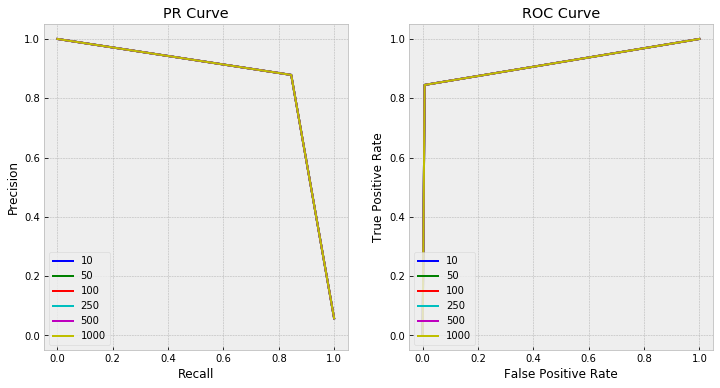

In [52]:
# Unsampled training data # rf_prec_recall_n_est_unsampled_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([10, 50, 100, 250, 500,1000],'bgrcmy'):
    print(n_est)
    RandomForestClassifier(n_estimators=n_est, max_depth=None, random_state=0, n_jobs=-1)
    rf.fit(X_train,Y_train)
    y_pred = rf.predict(X_test)

    p,r,_ = precision_recall_curve(Y_test, y_pred)
    tpr,fpr,_ = roc_curve(Y_test, y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
